
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator


from sklearn.model_selection import cross_val_score

import sklearn.metrics as metrics

## Whether to buy or not to buy apple


In this notebook we use Machine Learning to decide whether to buy or not to buy apple stock.

In [ ]:
import datetime
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, NotFittedError

In this analysis we will consider the `Apple` and `Microsoft` stock prices since common sense tell us that they may affect each other. Moreover, we wil consider historical data only from 2015 to today, because AAPLE had considered liquidity to take into account since 2015 .

In [ ]:
START_DATE = datetime.datetime(2010,1,1)
END_DATE = datetime.date.today()
SLIDING_WINDOW_SIZE = 250

In [ ]:
def add_predict_variable_raise_relative_to_last_window(df, window):
    """
    Predict variable is 1 if tomorrow is above average of the last window,
    0 otherwise.
    """
    
    close_tomorrow = df["AAPL_close"].shift(periods=-1)
    avg_last_window= df["AAPL_close"].rolling(window).mean()
    df.iloc[:window].dropna()
    df["tomorrow_rises_relative_to_window"] = (close_tomorrow > avg_last_window)
    labelencoder = preprocessing.LabelEncoder()
    df["tomorrow_rises_relative_to_window"] = labelencoder.fit_transform(df["tomorrow_rises_relative_to_window"])
    return df

In [ ]:
def load_data(start_date, end_date):
    stocks = ["AAPL", "MSFT", "^NDX", "^DJA", "^GSPC"]
    all_dataframes = []
    for s in stocks:
        df = pdr.get_data_yahoo(s, start=start_date, end=end_date)
        df[f"{s}_volume"] = df["Volume"]
        df[f"{s}_close"] = df["Adj Close"]
        df = df[[f"{s}_volume", f"{s}_close"]]   
        all_dataframes.append(df)
    df = pd.concat(all_dataframes, axis=1, sort=False)
    y=add_predict_variable_raise_relative_to_last_window(df, 30)
    return df

In [ ]:
df = load_data(START_DATE, END_DATE)
df

,AAPL_volume,AAPL_close,MSFT_volume,MSFT_close,^NDX_volume,^NDX_close,^DJA_volume,^DJA_close,^GSPC_volume,^GSPC_close,tomorrow_rises_relative_to_window
Date,,,,,,,,,,,
2010-01-04,123432400.0,26.419203,38409100.0,24.226894,1931380000,1886.699951,3991400000,3604.739990,3991400000,1132.989990,0
2010-01-05,150476200.0,26.464878,49749600.0,24.234720,2367860000,1888.430054,2491020000,3606.760010,2491020000,1136.520020,0
2010-01-06,138040000.0,26.043921,58182400.0,24.085989,2253340000,1878.420044,4972660000,3605.360107,4972660000,1137.140015,0
2010-01-07,119282800.0,25.995777,50559700.0,23.835503,2270050000,1876.719971,5270680000,3605.300049,5270680000,1141.689941,0
2010-01-08,111902700.0,26.168606,51197400.0,23.999893,2145390000,1892.589966,4389590000,3629.419922,4389590000,1144.979980,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-06,50607200.0,454.790009,32656800.0,216.350006,4086290000,11267.080078,4267490000,8952.740234,4267490000,3349.159912,1
2020-08-07,49453300.0,444.450012,27789600.0,212.479996,4230720000,11139.389648,4104860000,9040.580078,4104860000,3351.280029,1
2020-08-10,53100900.0,450.910004,36716500.0,208.250000,4018530000,11085.169922,4318570000,9166.379883,4318570000,3360.469971,1


In [ ]:
last_year_start = END_DATE.replace(END_DATE.year - 1)
last_year_start

datetime.date(2019, 8, 13)

In [ ]:
df_test = df.loc[last_year_start:]
df_train = df.loc[:last_year_start]

In [ ]:
df_test.head()

,AAPL_volume,AAPL_close,MSFT_volume,MSFT_close,^NDX_volume,^NDX_close,^DJA_volume,^DJA_close,^GSPC_volume,^GSPC_close,tomorrow_rises_relative_to_window
Date,,,,,,,,,,,
2019-08-13,47218500.0,206.917007,25154600.0,136.915222,2346980000,7728.149902,3853600000,8695.740234,3853600000,2926.320068,0
2019-08-14,36547400.0,200.758102,32527300.0,132.792084,2522870000,7490.129883,4312530000,8464.660156,4312530000,2840.600098,0
2019-08-15,27227400.0,199.758026,28074400.0,132.494751,2182590000,7484.890137,4038000000,8486.360352,4038000000,2847.600098,1
2019-08-16,27620400.0,204.471252,24449100.0,134.923050,1995130000,7604.109863,3498150000,8592.809570,3498150000,2888.679932,1
2019-08-19,24413600.0,208.283447,24355700.0,137.182831,1934980000,7719.319824,3212880000,8674.320312,3212880000,2923.649902,1


In [ ]:
df_train.head()

,AAPL_volume,AAPL_close,MSFT_volume,MSFT_close,^NDX_volume,^NDX_close,^DJA_volume,^DJA_close,^GSPC_volume,^GSPC_close,tomorrow_rises_relative_to_window
Date,,,,,,,,,,,
2010-01-04,123432400.0,26.419203,38409100.0,24.226894,1931380000,1886.699951,3991400000,3604.739990,3991400000,1132.989990,0
2010-01-05,150476200.0,26.464878,49749600.0,24.234720,2367860000,1888.430054,2491020000,3606.760010,2491020000,1136.520020,0
2010-01-06,138040000.0,26.043921,58182400.0,24.085989,2253340000,1878.420044,4972660000,3605.360107,4972660000,1137.140015,0
2010-01-07,119282800.0,25.995777,50559700.0,23.835503,2270050000,1876.719971,5270680000,3605.300049,5270680000,1141.689941,0
2010-01-08,111902700.0,26.168606,51197400.0,23.999893,2145390000,1892.589966,4389590000,3629.419922,4389590000,1144.979980,0


In [ ]:
df_train.reset_index(inplace=True)
df_train.head()

,Date,AAPL_volume,AAPL_close,MSFT_volume,MSFT_close,^NDX_volume,^NDX_close,^DJA_volume,^DJA_close,^GSPC_volume,^GSPC_close,tomorrow_rises_relative_to_window
0,2010-01-04,123432400.0,26.419203,38409100.0,24.226894,1931380000,1886.699951,3991400000,3604.739990,3991400000,1132.989990,0
1,2010-01-05,150476200.0,26.464878,49749600.0,24.234720,2367860000,1888.430054,2491020000,3606.760010,2491020000,1136.520020,0
2,2010-01-06,138040000.0,26.043921,58182400.0,24.085989,2253340000,1878.420044,4972660000,3605.360107,4972660000,1137.140015,0
3,2010-01-07,119282800.0,25.995777,50559700.0,23.835503,2270050000,1876.719971,5270680000,3605.300049,5270680000,1141.689941,0
4,2010-01-08,111902700.0,26.168606,51197400.0,23.999893,2145390000,1892.589966,4389590000,3629.419922,4389590000,1144.979980,0


## Define preprocessing steps

In [ ]:
class TimeSeriesFeature(TransformerMixin, BaseEstimator):
    """
    Parameters
    ----------
    period: its the sliding number of items which will take into account to
        make the average. 

    Attributes
    ----------
    """
    def __init__(self, period=2, name_sufix=None):
        self.period = period
        self.expected_column_names_ = None
        self.created_column_names_ = None
        self.last_period_data_ = None
        if name_sufix is None:
            raise RuntimeError
        self.name_sufix = name_sufix

    def fit_transform(self, X, y=None):
        raise NotImplementedError

    def _handle_column_names(self, columns):
        if self.expected_column_names_ is None or self.created_column_names_ is None:
  
  
  
            self.expected_column_names_ = columns
            self.created_column_names_ = [
                x + self.name_sufix for x in self.expected_column_names_
            ]
        else:
            if columns != self.expected_column_names_:
                msg = "Invalid column names, expected: {}, got {}"
                raise ValueError(msg.format(
                    self.expected_column_names_, columns
                ))

    def _handle_last_period_data(self, X):
        num_samples = X.shape[0]
        if self.last_period_data_ is None:
            if num_samples < self.period:
                msg =(
                    "{} can't be computed with number of samples "
                    "({}) smaller than period ({}) "
                ) 
                raise NotFittedError(msg.format(type(self), num_samples, self.period))
        else:
            X = np.concatenate([self.last_period_data_, X], axis=0)
        self.last_period_data_ = X[-(self.period-1):, :]
        return X

    def _handle_conatenation(self, X, X_means):
        num_samples = X.shape[0]
        num_means = X_means.shape[0]
        X_means = X_means[-num_samples:, :]
        X_new = np.concatenate([X, X_means], axis=1)
        return X_new

In [ ]:
class TimeSeriesFeature2(TransformerMixin, BaseEstimator):
    """
    Parameters
    ----------
    period: its the sliding number of items which will take into account to
        make the average. 

    Attributes
    ----------
    """
    def __init__(self, periodshort=12,periodlong=36, name_sufix=None):
        self.periodshort = periodshort
        self.periodlong = periodlong
        self.expected_column_names_ = None
        self.created_column_names_ = None
        self.last_period_data_ = None
        if name_sufix is None:
            raise RuntimeError
        self.name_sufix = name_sufix

    def fit_transform(self, X, y=None):
        raise NotImplementedError

    
    def _handle_column_names(self, columns):
        if self.expected_column_names_ is None or self.created_column_names_ is None:
            self.expected_column_names_ = columns
            self.created_column_names_ = [
                x + self.name_sufix for x in self.expected_column_names_
            ]
        else:
            if columns != self.expected_column_names_:
                msg = "Invalid column names, expected: {}, got {}"
                raise ValueError(msg.format(
                    self.expected_column_names_, columns
                ))

    def _handle_last_period_data(self, X):
        num_samples = X.shape[0]
        if self.last_period_data_ is None:
            if num_samples < self.periodlong:
                msg =(
                    "{} can't be computed with number of samples "
                    "({}) smaller than period ({}) "
                ) 
                raise NotFittedError(msg.format(type(self), num_samples, self.periodlong))
        else:
            X = np.concatenate([self.last_period_data_, X], axis=0)
        self.last_period_data_ = X[-(self.periodlong-1):, :]
        return X

    def _handle_conatenation(self, X, X_means):
        num_samples = X.shape[0]
        num_means = X_means.shape[0]
        X_means = X_means[-num_samples:, :]
        X_new = np.concatenate([X, X_means], axis=1)
        return X_new

In [ ]:
class MovingAverage(TimeSeriesFeature):
    """
    Computes the moving average for a number of items in a column which will 
    be determined for the window size and this result will be adds  to an extra 
    column.The lenght of this new column will be window size items less than 
    original.

    Parameters
    ----------
    period: its the sliding number of items which will take into account to
        make the average. 

    Attributes
    ----------
    """
    def __init__(self, period=2):
        super().__init__(period=period, name_sufix="ma")

    def fit_transform(self, X, y=None):
        return_dataframe = False
        if isinstance(X, pd.DataFrame):
            return_dataframe = True
            self._handle_column_names(list(X.columns))
        X_new = check_array(X)
        X_new = self._handle_last_period_data(X_new)
        X_mean_values = pd.DataFrame(X_new).rolling(self.period).mean().values
        X_new = self._handle_conatenation(X, X_mean_values)
        if return_dataframe:
            X_new = pd.DataFrame(X_new, columns=self.expected_column_names_ + self.created_column_names_)
        return X_new

In [ ]:
obj = MovingAverage(period=3)
obj

MovingAverage(period=3)

In [ ]:
df_ = df_train[["MSFT_close", "AAPL_close","^NDX_close","^DJA_close","^GSPC_close"]]
df_.head()

,MSFT_close,AAPL_close,^NDX_close,^DJA_close,^GSPC_close
0,24.226894,26.419203,1886.699951,3604.739990,1132.989990
1,24.234720,26.464878,1888.430054,3606.760010,1136.520020
2,24.085989,26.043921,1878.420044,3605.360107,1137.140015
3,23.835503,25.995777,1876.719971,3605.300049,1141.689941
4,23.999893,26.168606,1892.589966,3629.419922,1144.979980


In [ ]:
x_ = obj.fit_transform(df_)
x_.head()

,MSFT_close,AAPL_close,^NDX_close,^DJA_close,^GSPC_close,MSFT_closema,AAPL_closema,^NDX_closema,^DJA_closema,^GSPC_closema
0,24.226894,26.419203,1886.699951,3604.739990,1132.989990,NaN,NaN,NaN,NaN,NaN
1,24.234720,26.464878,1888.430054,3606.760010,1136.520020,NaN,NaN,NaN,NaN,NaN
2,24.085989,26.043921,1878.420044,3605.360107,1137.140015,24.182535,26.309334,1884.516683,3605.620036,1135.550008
3,23.835503,25.995777,1876.719971,3605.300049,1141.689941,24.052071,26.168192,1881.190023,3605.806722,1138.449992
4,23.999893,26.168606,1892.589966,3629.419922,1144.979980,23.973795,26.069434,1882.576660,3613.360026,1141.269979


In [ ]:
x_.tail()

,MSFT_close,AAPL_close,^NDX_close,^DJA_close,^GSPC_close,MSFT_closema,AAPL_closema,^NDX_closema,^DJA_closema,^GSPC_closema
2414,133.635544,196.338562,7551.899902,8629.230469,2883.979980,132.430394,193.793579,7496.303223,8595.640299,2870.163330
2415,137.201691,200.668991,7724.830078,8751.500000,2938.090088,134.629995,197.111267,7599.349935,8671.153646,2901.280029
2416,136.036041,199.015396,7646.270020,8711.580078,2918.649902,135.624425,198.674316,7641.000000,8697.436849,2913.573324
2417,134.139359,198.510406,7561.680176,8596.709961,2882.699951,135.792363,199.398265,7644.260091,8686.596680,2913.146647
2418,136.915222,206.917007,7728.149902,8695.740234,2926.320068,135.696874,201.480937,7645.366699,8668.010091,2909.223307


In [ ]:
obj.last_period_data_

array([[ 134.13935852,  198.51040649, 7561.68017578, 8596.70996094,
        2882.69995117],
       [ 136.91522217,  206.91700745, 7728.14990234, 8695.74023438,
        2926.32006836]])

In [ ]:
slice_ = df_.iloc[40:41, :]
slice_

,MSFT_close,AAPL_close,^NDX_close,^DJA_close,^GSPC_close
40,22.381964,25.841471,1851.569946,3531.399902,1118.790039


In [ ]:
obj.fit_transform(slice_)

,MSFT_close,AAPL_close,^NDX_close,^DJA_close,^GSPC_close,MSFT_closema,AAPL_closema,^NDX_closema,^DJA_closema,^GSPC_closema
0,22.381964,25.841471,1851.569946,3531.399902,1118.790039,97.812181,143.756295,5713.800008,6941.283366,2309.27002


In [ ]:
obj.last_period_data_

array([[ 136.91522217,  206.91700745, 7728.14990234, 8695.74023438,
        2926.32006836],
       [  22.38196373,   25.84147072, 1851.56994629, 3531.39990234,
        1118.79003906]])

In [ ]:
class MovingAverageEXP(TimeSeriesFeature):
    """
    Computes the moving average for a number of items in a column which will 
    be determined for the window size and this result will be adds  to an extra 
    column.The lenght of this new column will be window size items less than 
    original. It will allocate highest weight to more recent data.

    Parameters
    ----------
    period: its the sliding number of items which will take into account to
        make the average. 

    Attributes
    ----------
    """
    def __init__(self, period=2):
        super().__init__(period=period, name_sufix="maEXP")

    def fit_transform(self, X, y=None):
        return_dataframe = False
        if isinstance(X, pd.DataFrame):
            return_dataframe = True
            self._handle_column_names(list(X.columns))
        X_new = check_array(X)
        X_new = self._handle_last_period_data(X_new)
        X_mean_values = pd.DataFrame(X_new).ewm(span=self.period,min_periods=self.period,adjust=False,ignore_na=False).mean().values
        X_new = self._handle_conatenation(X, X_mean_values)
        if return_dataframe:
            X_new = pd.DataFrame(X_new, columns=self.expected_column_names_ + self.created_column_names_)
        return X_new

In [ ]:
obj = MovingAverageEXP()
obj

MovingAverageEXP(period=2)

In [ ]:
x_ = obj.fit_transform(df_)
x_.head()


,MSFT_close,AAPL_close,^NDX_close,^DJA_close,^GSPC_close,MSFT_closemaEXP,AAPL_closemaEXP,^NDX_closemaEXP,^DJA_closemaEXP,^GSPC_closemaEXP
0,24.226894,26.419203,1886.699951,3604.739990,1132.989990,NaN,NaN,NaN,NaN,NaN
1,24.234720,26.464878,1888.430054,3606.760010,1136.520020,24.232112,26.449653,1887.853353,3606.086670,1135.343343
2,24.085989,26.043921,1878.420044,3605.360107,1137.140015,24.134697,26.179165,1881.564480,3605.602295,1136.541124
3,23.835503,25.995777,1876.719971,3605.300049,1141.689941,23.935234,26.056906,1878.334807,3605.400798,1139.973669
4,23.999893,26.168606,1892.589966,3629.419922,1144.979980,23.978340,26.131373,1887.838246,3621.413547,1143.311210


In [ ]:
class Macd(TimeSeriesFeature2):
    """
    Moving Average Convergence Divergence its a signal from histogram which
    indicate how will behave the asset in the market. It has to be compare with
    short MACD EWMA( usually 9 periods). In a chart If MACD cut their short 
    EWMA up it is a buy signal otherwise if it cut down it's sell signal  
    
    MACD = EWMA12-EWMA 26  

    Parameters
    ----------
    window1=its 12 periods which use to calculate MACD
    window2= its 36 periods which use to calculate MACD
    window3= its usually 9 periods to calculate short MACD EWMA

     Examples
    --------
    >>> from skltemplate import Macd
    >>> import numpy as np
    >>> import pandas as pd

    >>> X = df
    >>> 
    >>> estimator = EWMA()
    >>> estimator.fit(X)
    EWMA(df,window1='window1',window2='window2',window3='window3')
    stocks = ["AAPL", "MSFT", "^NDX", "^DJA", "^GSPC"]    
  for s in stocks:     
    df[f"{s}_MA12"]=df[f"{s}_close"].ewm(span=window1,min_periods=window1,adjust=False,ignore_na=False).mean() 
    df[f"{s}_MA36"]=df[f"{s}_close"].ewm(span=window2,min_periods=window2,adjust=False,ignore_na=False).mean()
    d12=df[f"{s}_MA12"].iloc[window1:]
    d16=df[f"{s}_MA36"].iloc[window2:]
    df[f"{s}_MACD"] = d12-d16
    df[f"{s}_Signal"] = df[f"{s}_MACD"].ewm(span=window,min_periods=window,adjust=False,ignore_na=False).mean()
    stocks = ["AAPL", "MSFT", "^NDX", "^DJA", "^GSPC"]    
    for s in stocks:
      df[f"{s}_Signal"] = df[f"{s}_MACD"].ewm(span=window3,min_periods=window3,adjust=False,ignore_na=False).mean()
    return df

    """


    def __init2__(self, periodshort=12,periodlong=36):
        super().__init1__(periodshort=periodshort,periodlong=periodlong,name_sufix="macd")

    def fit_transform(self, X, y=None):
        return_dataframe = False
        if isinstance(X, pd.DataFrame):
            return_dataframe = True
            self._handle_column_names(list(X.columns))
        X_new = check_array(X)
        X_new = self._handle_last_period_data(X_new)
        X_36 = pd.DataFrame(X_new).ewm(span=self.periodlong,min_periods=self.periodlong,adjust=False,ignore_na=False).mean().values
        X_12 = pd.DataFrame(X_new).ewm(span=self.periodshort,min_periods=self.periodshort,adjust=False,ignore_na=False).mean().values
        X_mean_values= X_12-X_36
        X_new = self._handle_conatenation(X, X_mean_values)
        if return_dataframe:
            X_new = pd.DataFrame(X_new, columns=self.expected_column_names_ + self.created_column_names_)
        return X_new
   
   

In [ ]:
obj = Macd()
obj

Macd()

In [ ]:
x_ = obj.fit_transform(df_)
x_.head()

AttributeError: ignored

In [ ]:
class ROC(TimeSeriesFeature):
    """
    Price Rate Of Change (ROC) indicator is a momentum-based technical indicator that measures the percentage change in price between the current price and the price a certain number of periods ago. 

    Parameters
    ----------
    window= certain number of periods ago

     Examples
    --------
    >>> from skltemplate import roc
    >>> import numpy as np
    >>> import pandas as pd

    >>> X = df
    >>> 
    >>> estimator = roc()
    >>> estimator.fit(X)
    roc(df,window='window')

    
    M = df[f"{s}_close"].diff(window - 1)
    N = df[f"{s}_close"].shift(window - 1)
    df[f"{s}_ROC"]= M / N
    
    >>> X = df
    
    

    """
    def __init__(self, period=2):
        super().__init__(period=period, name_sufix="roc")

    def fit_transform(self, X, y=None):
        return_dataframe = False
        if isinstance(X, pd.DataFrame):
            return_dataframe = True
            self._handle_column_names(list(X.columns))
        X_new = check_array(X)
        X_new = self._handle_last_period_data(X_new)
        X_Diff= pd.DataFrame(X_new).diff(self.period-1).values
        X_Shift= pd.DataFrame(X_new).shift(self.period-1).values
        X_total_values= X_Diff/X_Shift
        X_new = self._handle_conatenation(X, X_total_values)
        if return_dataframe:
            X_new = pd.DataFrame(X_new, columns=self.expected_column_names_ + self.created_column_names_)
        return X_new

In [ ]:
obj = ROC()
obj

ROC(period=2)

In [ ]:
x_ = obj.fit_transform(df_)
x_.head()

,MSFT_close,AAPL_close,^NDX_close,^DJA_close,^GSPC_close,MSFT_closeroc,AAPL_closeroc,^NDX_closeroc,^DJA_closeroc,^GSPC_closeroc
0,24.226894,26.419203,1886.699951,3604.739990,1132.989990,NaN,NaN,NaN,NaN,NaN
1,24.234720,26.464878,1888.430054,3606.760010,1136.520020,0.000323,0.001729,0.000917,0.000560,0.003116
2,24.085989,26.043921,1878.420044,3605.360107,1137.140015,-0.006137,-0.015906,-0.005301,-0.000388,0.000546
3,23.835503,25.995777,1876.719971,3605.300049,1141.689941,-0.010400,-0.001849,-0.000905,-0.000017,0.004001
4,23.999893,26.168606,1892.589966,3629.419922,1144.979980,0.006897,0.006648,0.008456,0.006690,0.002882


In [ ]:
class Stocasticoscillator(TimeSeriesFeature):
    """
    this metric compare asset price with its maximun and minimun on a certain period. You could compare it with their short EWMA and depend on where it cross it will have the same conclution as MACD regarding buy and sell signal. However in this case just will take into account this oscillator alone in a range of 0 and 1 where 1 its the maximun and cero is the minimun. This measure help to standarice data. 
    
    Parameters
    ----------
    window= certain number of periods ago to compare 

    Result

    if Stochastic oscillator is more than 0.8 the asset is overbuying so its a sell signal otherwise if this measure is less than 0.2 , the aseet is overselling and its a buy signal. 

     Examples
    --------
    >>> from skltemplate import roc
    >>> import numpy as np
    >>> import pandas as pd

    >>> X = df
    >>> 
    >>> estimator = roc()
    >>> estimator.fit(X)
    roc(df,window='window')

      stocks = ["AAPL", "MSFT", "^NDX", "^DJA", "^GSPC"] 
  for s in stocks:

    minimo=df[f"{s}_close"].rolling(window).min()
    maximo=df[f"{s}_close"].rolling(window).max()
    

    df[f"{s}_Stocastic Oscillator"] = (df[f"{s}_close"]-minimo)/(maximo-minimo)
    
    

    """
    def __init__(self, period=2):
        super().__init__(period=period, name_sufix="_ST")

    def fit_transform(self, X, y=None):
        return_dataframe = False
        if isinstance(X, pd.DataFrame):
            return_dataframe = True
            self._handle_column_names(list(X.columns))
        X_new = check_array(X)
        X_new = self._handle_last_period_data(X_new)
        X_Min= pd.DataFrame(X_new).rolling(self.period).min().values
        X_Max= pd.DataFrame(X_new).rolling(self.period).max().values
        X_ST_values= (X_new-X_Min)/(X_Max-X_Min)
        X_new = self._handle_conatenation(X, X_ST_values)
        if return_dataframe:
            X_new = pd.DataFrame(X_new, columns=self.expected_column_names_ + self.created_column_names_)
        return X_new

In [ ]:
obj = Stocasticoscillator(period=3)
obj

Stocasticoscillator(period=3)

In [ ]:
x_ = obj.fit_transform(df_)
x_.head()

,MSFT_close,AAPL_close,^NDX_close,^DJA_close,^GSPC_close,MSFT_close_ST,AAPL_close_ST,^NDX_close_ST,^DJA_close_ST,^GSPC_close_ST
0,24.226894,26.419203,1886.699951,3604.739990,1132.989990,NaN,NaN,NaN,NaN,NaN
1,24.234720,26.464878,1888.430054,3606.760010,1136.520020,NaN,NaN,NaN,NaN,NaN
2,24.085989,26.043921,1878.420044,3605.360107,1137.140015,0.000000,0.0,0.0,0.306986,1.0
3,23.835503,25.995777,1876.719971,3605.300049,1141.689941,0.000000,0.0,0.0,0.000000,1.0
4,23.999893,26.168606,1892.589966,3629.419922,1144.979980,0.656285,1.0,1.0,1.000000,1.0


In [ ]:
x_.head

<bound method NDFrame.head of       MSFT_close  AAPL_close  ...  ^DJA_close_ST  ^GSPC_close_ST
0      24.226894   26.419203  ...            NaN             NaN
1      24.234720   26.464878  ...            NaN             NaN
2      24.085989   26.043921  ...       0.306986        1.000000
3      23.835503   25.995777  ...       0.000000        1.000000
4      23.999893   26.168606  ...       1.000000        1.000000
...          ...         ...  ...            ...             ...
2414  133.635544  196.338562  ...       0.967524        1.000000
2415  137.201691  200.668991  ...       1.000000        1.000000
2416  136.036041  199.015396  ...       0.673509        0.640729
2417  134.139359  198.510406  ...       0.000000        0.000000
2418  136.915222  206.917007  ...       0.862106        1.000000

[2419 rows x 10 columns]>

In [ ]:
x_

,MSFT_close,AAPL_close,^NDX_close,^DJA_close,^GSPC_close,MSFT_close_ST,AAPL_close_ST,^NDX_close_ST,^DJA_close_ST,^GSPC_close_ST
0,24.226894,26.419203,1886.699951,3604.739990,1132.989990,NaN,NaN,NaN,NaN,NaN
1,24.234720,26.464878,1888.430054,3606.760010,1136.520020,NaN,NaN,NaN,NaN,NaN
2,24.085989,26.043921,1878.420044,3605.360107,1137.140015,0.000000,0.000000,0.000000,0.306986,1.000000
3,23.835503,25.995777,1876.719971,3605.300049,1141.689941,0.000000,0.000000,0.000000,0.000000,1.000000
4,23.999893,26.168606,1892.589966,3629.419922,1144.979980,0.656285,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
2414,133.635544,196.338562,7551.899902,8629.230469,2883.979980,1.000000,1.000000,1.000000,0.967524,1.000000
2415,137.201691,200.668991,7724.830078,8751.500000,2938.090088,1.000000,1.000000,1.000000,1.000000,1.000000
2416,136.036041,199.015396,7646.270020,8711.580078,2918.649902,0.673135,0.618145,0.545712,0.673509,0.640729
2417,134.139359,198.510406,7561.680176,8596.709961,2882.699951,0.000000,0.000000,0.000000,0.000000,0.000000


## Model training

In [ ]:
model = Pipeline(
    [
        ("media movil", MovingAverage() ),
        ("media movil exponencial", Stocasticoscillator()),
        ("ROC", ROC()),
        ("Stocasticoscillator", Stocasticoscillator()),
        ("clf", LogisticRegression())
     
    ],
    memory="cache_logistic_regression_pipeline"
)
model

TypeError: ignored

In [ ]:
date = df.index[...]
year = date.strftime("%Y")
df["Year"]= year

month = date.strftime("%m")
df["month"]=month

day = date.strftime("%d")
df["day"]=day

df

,AAPL_volume,AAPL_close,MSFT_volume,MSFT_close,^NDX_volume,^NDX_close,^DJA_volume,^DJA_close,^GSPC_volume,^GSPC_close,tomorrow_rises_relative_to_window,Year,month,day
Date,,,,,,,,,,,,,,
2010-01-04,123432400.0,26.466835,38409100.0,24.226894,1931380000,1886.699951,3991400000,3604.739990,3991400000,1132.989990,0,2010,01,04
2010-01-05,150476200.0,26.512596,49749600.0,24.234720,2367860000,1888.430054,2491020000,3606.760010,2491020000,1136.520020,0,2010,01,05
2010-01-06,138040000.0,26.090879,58182400.0,24.085989,2253340000,1878.420044,4972660000,3605.360107,4972660000,1137.140015,0,2010,01,06
2010-01-07,119282800.0,26.042646,50559700.0,23.835503,2270050000,1876.719971,5270680000,3605.300049,5270680000,1141.689941,0,2010,01,07
2010-01-08,111902700.0,26.215786,51197400.0,23.999893,2145390000,1892.589966,4389590000,3629.419922,4389590000,1144.979980,0,2010,01,08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27,30303500.0,379.239990,30160900.0,203.850006,4209900000,10674.379883,3963910000,8660.919922,3963910000,3239.409912,1,2020,07,27
2020-07-28,25906400.0,373.010010,23251400.0,202.020004,3869230000,10532.500000,4027890000,8618.929688,4027890000,3218.439941,1,2020,07,28
2020-07-29,22582300.0,380.160004,19632600.0,204.059998,3970900000,10662.980469,4676300000,8700.769531,4676300000,3258.439941,1,2020,07,29


In [ ]:
def add_moving_averages(df, window): 
  stocks = ["AAPL", "MSFT", "^NDX", "^DJA", "^GSPC"]    
  for s in stocks:
    df[f"{s}_MA"] = df[f"{s}_close"].rolling(window).mean() 
    
  return df
    



In [ ]:
def add_EWMA(df, window): 
  stocks = ["AAPL", "MSFT", "^NDX", "^DJA", "^GSPC"]    
  for s in stocks:
    df[f"{s}_EWMA"] = df[f"{s}_close"].ewm(span=window,min_periods=window,adjust=False,ignore_na=False).mean()
   

    
    
  return df


In [ ]:
def add_macd(df,window1=12,window2=36,window3=9): 
  stocks = ["AAPL", "MSFT", "^NDX", "^DJA", "^GSPC"]    
  for s in stocks:     
    df[f"{s}_MA12"]=df[f"{s}_close"].ewm(span=window1,min_periods=window1,adjust=False,ignore_na=False).mean() 
    df[f"{s}_MA36"]=df[f"{s}_close"].ewm(span=window2,min_periods=window2,adjust=False,ignore_na=False).mean()
    d12=df[f"{s}_MA12"].iloc[window1:]
    d16=df[f"{s}_MA36"].iloc[window2:]
    df[f"{s}_MACD"] = d12-d16
    
    stocks = ["AAPL", "MSFT", "^NDX", "^DJA", "^GSPC"]    
    for s in stocks:
      df[f"{s}_Signal"] = df[f"{s}_MACD"].ewm(span=window3,min_periods=window3,adjust=False,ignore_na=False).mean()
    return df



In [ ]:
def add_macd(df,window1=12,window2=36,window3=9): 
  stocks = ["AAPL", "MSFT", "^NDX", "^DJA", "^GSPC"]    
  for s in stocks:     
    df[f"{s}_MA12"]=df[f"{s}_close"].ewm(span=window1,min_periods=window1,adjust=False,ignore_na=False).mean() 
    df[f"{s}_MA36"]=df[f"{s}_close"].ewm(span=window2,min_periods=window2,adjust=False,ignore_na=False).mean()
    d12=df[f"{s}_MA12"].iloc[window1:]
    d16=df[f"{s}_MA36"].iloc[window2:]
    df[f"{s}_MACD"] = d12-d16
  return df[f"{s}_MACD"]  

In [ ]:
r=add_macd(df)
r.head(40)
r.shape
df.shape



(2648, 27)

In [ ]:
def add_roc(df,window=30):
  stocks = ["AAPL", "MSFT", "^NDX", "^DJA", "^GSPC"]     
  for s in stocks:
    M = df[f"{s}_close"].diff(window - 1)
    
    df[f"{s}_ROC"]= (M-1)*100
  return df

 

In [ ]:
def add_stochastic_oscillator(df,window=30):
 

  stocks = ["AAPL", "MSFT", "^NDX", "^DJA", "^GSPC"] 
  for s in stocks:

    minimo=df[f"{s}_close"].rolling(window).min()
    maximo=df[f"{s}_close"].rolling(window).max()
    

    df[f"{s}_Stocastic Oscillator"] = (df[f"{s}_close"]-minimo)/(maximo-minimo)

  return df

In [ ]:
def RSI(df,window=30):
 

  stocks = ["AAPL", "MSFT", "^NDX", "^DJA", "^GSPC"] 
  for s in stocks:
    for s in df[f"{s}_close"].rolling(window):
      r=s

      
      maximo=df[f"{s}_close"].rolling(window)
    

    df[f"{s}_Stocastic Oscillator"] = (df[f"{s}_close"]-minimo)/(maximo-minimo)

    return maximo


In [ ]:
def add_predict_variable_next_day(df):
    """
    Adds to the dataframe the predictor variable such that it corresponds to the
    value of the closing price the next day.
    """    
    close = df["AAPL_close"].shift(periods=-1)
    df["close_next_day"] = close
    return df

In [ ]:
def add_predict_variable_raise_relative_to_last_window(df, window):
    """
    Predict variable is 1 if tomorrow is above average of the last window,
    0 otherwise.
    """
    
    close_tomorrow = df["AAPL_close"].shift(periods=-1)
    avg_last_window= df["AAPL_close"].rolling(window).mean()
    df.iloc[:window].dropna()
    df["tomorrow_rises_relative_to_window"] = (close_tomorrow > avg_last_window)
    
    
       
    return df

In [ ]:
df['middle_band'] = df["AAPL_close"].rolling(window=20).mean()
df['upper_band'] = df["AAPL_close"].rolling(window=20).mean() + df["AAPL_close"].rolling(window=20).std()*2
df['lower_band'] = df["AAPL_close"].rolling(window=20).mean() - df["AAPL_close"].rolling(window=20).std()*2
df=add_moving_averages(df, 200)

In [ ]:
df=add_EWMA(df,20)
df=add_macd(df)
df=add_roc(df)
df=add_stochastic_oscillator(df)
df=add_predict_variable_next_day(df)
df=add_predict_variable_raise_relative_to_last_window(df,30)
df=df.dropna()
df


,AAPL_volume,AAPL_close,MSFT_volume,MSFT_close,^NDX_volume,^NDX_close,^DJA_volume,^DJA_close,^GSPC_volume,^GSPC_close,Year,month,day,middle_band,upper_band,lower_band,AAPL_MA,MSFT_MA,^NDX_MA,^DJA_MA,^GSPC_MA,AAPL_EWMA,MSFT_EWMA,^NDX_EWMA,^DJA_EWMA,^GSPC_EWMA,AAPL_MA12,AAPL_MA36,AAPL_MACD,AAPL_Signal,MSFT_MA12,MSFT_MA36,MSFT_MACD,MSFT_Signal,^NDX_MA12,^NDX_MA36,^NDX_MACD,^NDX_Signal,^DJA_MA12,^DJA_MA36,^DJA_MACD,^DJA_Signal,^GSPC_MA12,^GSPC_MA36,^GSPC_MACD,^GSPC_Signal,AAPL_ROC,MSFT_ROC,^NDX_ROC,^DJA_ROC,^GSPC_ROC,AAPL_Stocastic Oscillator,MSFT_Stocastic Oscillator,^NDX_Stocastic Oscillator,^DJA_Stocastic Oscillator,^GSPC_Stocastic Oscillator,close_next_day,tomorrow_rises_relative_to_window
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-10-18,273252700.0,39.327400,48330500.0,20.506207,1724710000,2104.149902,4450050000,3867.449951,4450050000,1184.709961,2010,10,18,36.195859,38.682370,33.709347,30.358962,21.411175,1889.766904,3607.688706,1120.764647,36.206025,19.754515,2018.790614,3778.297782,1155.451538,37.031460,35.050551,1.980909,1.640104,19.878438,19.681323,0.197115,0.051408,2044.876821,1978.748214,66.128608,59.167898,3810.887634,3729.526333,81.361301,73.273728,1166.009485,1139.526560,26.482925,24.207474,0.233467,0.077630,0.133396,0.071538,0.085058,1.000000,1.000000,1.000000,1.000000,1.000000,38.274960,True
2010-10-19,308196000.0,38.274960,66150900.0,19.934381,2241840000,2069.729980,5600120000,3817.300049,5600120000,1165.900024,2010,10,19,36.354900,38.949267,33.760533,30.418003,21.389713,1890.682054,3608.751506,1120.929197,36.403067,19.771645,2023.641983,3782.012283,1156.446632,37.222767,35.224843,1.997924,1.711668,19.887045,19.695002,0.192043,0.079535,2048.700384,1983.666147,65.034237,60.341166,3811.874160,3734.270859,77.603301,74.139643,1165.992645,1140.952153,25.040492,24.374077,0.177126,0.048892,0.100920,0.051792,0.060999,0.845497,0.634517,0.846442,0.789392,0.780872,38.403580,True
2010-10-20,180406100.0,38.403580,56283600.0,20.101162,2016770000,2085.750000,5027880000,3871.530029,5027880000,1178.170044,2010,10,20,36.495761,39.217239,33.774284,30.477458,21.369045,1891.668654,3610.075356,1121.137447,36.593592,19.803028,2029.557032,3790.537783,1158.515528,37.404431,35.396667,2.007764,1.770887,19.919986,19.716956,0.203030,0.104234,2054.400325,1989.184193,65.216132,61.316159,3821.051986,3741.690273,79.361713,75.184057,1167.866091,1142.963931,24.902160,24.479694,0.180408,0.054144,0.105830,0.064739,0.067009,0.864009,0.741115,0.915601,1.000000,0.918789,38.278667,True
2010-10-21,137865000.0,38.278667,50032400.0,20.188524,2135480000,2090.100098,4625470000,3872.479980,4625470000,1180.260010,2010,10,21,36.623143,39.431027,33.815259,30.538397,21.349558,1892.727054,3611.410956,1121.353047,36.754075,19.839742,2035.323038,3798.341802,1160.586431,37.538929,35.552450,1.986478,1.814005,19.961299,19.742446,0.218853,0.127158,2059.892598,1994.639107,65.253491,62.103626,3828.963985,3748.759987,80.203998,76.188045,1169.772848,1144.979935,24.792912,24.542338,0.175050,0.065828,0.104506,0.063468,0.063729,0.844660,0.796953,0.933668,1.000000,0.940794,38.025139,True
2010-10-22,93194500.0,38.025139,25837900.0,20.156750,1648180000,2104.209961,3177890000,3869.699951,3177890000,1183.079956,2010,10,22,36.716824,39.582874,33.850775,30.598309,21.331164,1893.864504,3612.732955,1121.559997,36.875129,19.869933,2041.883697,3805.137816,1162.728672,37.613730,35.686109,1.927621,1.836729,19.991369,19.764841,0.226528,0.147032,2066.710654,2000.561856,66.148798,62.912660,3835.231057,3755.297282,79.933774,76.937191,1171.820095,1147.039396,24.780699,24.590010,0.151400,0.010752,0.094990,0.054486,0.054532,0.793367,0.769628,1.000000,0.986563,0.974375,38.194569,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-25,34380600.0,364.839996,27803900.0,200.339996,470

In [ ]:
print(f"Number of null values {df.isnull().sum().sum()} in a dataframe of shape {df.shape}")

Number of null values 0 in a dataframe of shape (2443, 58)


In [ ]:
stocks = ["AAPL", "MSFT", "^NDX", "^DJA", "^GSPC"]  
for s in stocks:  
  colnames = [f"{s}_MA", f"{s}_EWMA", f"{s}_MACD", f"{s}_Signal",
      f"{s}_ROC", f"{s}_Stocastic Oscillator", "tomorrow_rises_relative_to_window", "close_next_day"]
   
  for c in colnames:
    print(f"{c} has {df[c].isnull().sum()} null values")

AAPL_MA has 0 null values
AAPL_EWMA has 0 null values
AAPL_MACD has 0 null values
AAPL_Signal has 0 null values
AAPL_ROC has 0 null values
AAPL_Stocastic Oscillator has 0 null values
tomorrow_rises_relative_to_window has 0 null values
close_next_day has 0 null values
MSFT_MA has 0 null values
MSFT_EWMA has 0 null values
MSFT_MACD has 0 null values
MSFT_Signal has 0 null values
MSFT_ROC has 0 null values
MSFT_Stocastic Oscillator has 0 null values
tomorrow_rises_relative_to_window has 0 null values
close_next_day has 0 null values
^NDX_MA has 0 null values
^NDX_EWMA has 0 null values
^NDX_MACD has 0 null values
^NDX_Signal has 0 null values
^NDX_ROC has 0 null values
^NDX_Stocastic Oscillator has 0 null values
tomorrow_rises_relative_to_window has 0 null values
close_next_day has 0 null values
^DJA_MA has 0 null values
^DJA_EWMA has 0 null values
^DJA_MACD has 0 null values
^DJA_Signal has 0 null values
^DJA_ROC has 0 null values
^DJA_Stocastic Oscillator has 0 null values
tomorrow_rise

In [ ]:
labelencoder = LabelEncoder() 
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
df['tomorrow_rises_relative_to_window'].value_counts()


1    1578
0     865
Name: tomorrow_rises_relative_to_window, dtype: int64

In [ ]:
df.describe()

,AAPL_volume,AAPL_close,MSFT_volume,MSFT_close,^NDX_volume,^NDX_close,^DJA_volume,^DJA_close,^GSPC_volume,^GSPC_close,middle_band,upper_band,lower_band,AAPL_MA,MSFT_MA,^NDX_MA,^DJA_MA,^GSPC_MA,AAPL_EWMA,MSFT_EWMA,^NDX_EWMA,^DJA_EWMA,^GSPC_EWMA,AAPL_MA12,AAPL_MA36,AAPL_MACD,AAPL_Signal,MSFT_MA12,MSFT_MA36,MSFT_MACD,MSFT_Signal,^NDX_MA12,^NDX_MA36,^NDX_MACD,^NDX_Signal,^DJA_MA12,^DJA_MA36,^DJA_MACD,^DJA_Signal,^GSPC_MA12,^GSPC_MA36,^GSPC_MACD,^GSPC_Signal,AAPL_ROC,MSFT_ROC,^NDX_ROC,^DJA_ROC,^GSPC_ROC,AAPL_Stocastic Oscillator,MSFT_Stocastic Oscillator,^NDX_Stocastic Oscillator,^DJA_Stocastic Oscillator,^GSPC_Stocastic Oscillator,close_next_day,tomorrow_rises_relative_to_window
count,2.443000e+03,2443.000000,2.443000e+03,2443.000000,2.443000e+03,2443.000000,2.443000e+03,2443.000000,2.443000e+03,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000
mean,6.621247e+07,119.731303,3.811409e+07,60.925149,2.034167e+09,4754.088130,3.784997e+09,6347.944064,3.723423e+09,2084.417355,118.485711,125.430698,111.540724,108.848721,54.768534,4467.717255,6155.552645,2007.998350,118.510343,60.242219,4723.309875,6330.397097,2076.929954,119.010249,117.567350,1.442899,1.412580,60.523134,59.702822,0.820313,0.808209,4736.084173,4698.754957,37.329216,36.852731,6337.855133,6315.794250,22.060883,21.974294,2080.086172,2070.779689,9.306482,9.247667,0.031788,0.029605,0.020631,0.010794,0.013071,0.635601,0.656045,0.700694,0.659744,0.691767,119.864248,0.645927
std,5.116425e+07,69.063886,2.144430e+07,43.265660,6.520494e+08,2029.140989,2.155274e+09,1630.893259,8.828870e+08,585.881071,67.491216,72.457935,62.800548,58.285727,36.806253,1885.655244,1630.292572,575.547009,67.472810,42.437505,2005.344845,1627.247189,583.291451,68.102266,66.384108,4.810550,4.577691,42.765076,41.841562,1.771250,1.650666,2014.653031,1989.917154,99.219291,92.781101,1628.485380,1626.333464,108.394861,102.073845,584.264744,582.019318,35.355702,33.205538,0.094540,0.067604,0.053981,0.047598,0.047861,0.341387,0.318085,0.319331,0.322414,0.322189,69.221464,0.478329
min,1.136200e+07,37.163139,7.425600e+06,19.183052,3.671000e+07,2038.219971,2.105000e+08,3642.709961,1.025000e+09,1099.229980,36.195859,38.682370,33.709347,30.358962,20.674955,1889.766904,3607.688706,1120.764647,36.206025,19.624793,2018.790614,3778.297782,1155.451538,37.031460,35.050551,-25.002723,-20.566793,19.481353,19.681323,-11.573006,-9.101671,2044.876821,1978.748214,-724.392283,-595.400649,3772.221562,3729.526333,-1073.883397,-898.973957,1147.383099,1139.526560,-331.200606,-278.076852,-0.302224,-0.277417,-0.263735,-0.366046,-0.332536,0.000000,0.000000,0.000000,0.000000,0.000000,37.163139,0.000000
25%,2.949975e+07,67.352562,2.393335e+07,26.430906,1.735345e+09,2811.900024,3.230720e+09,4974.530029,3.230720e+09,1554.104980,67.772564,70.486560,63.104475,62.659096,24.912667,2700.143577,4515.960190,1430.727725,67.938478,26.104520,2802.682423,4926.600082,1542.697060,67.799033,68.155449,-0.406105,-0.379483,26.209592,25.885465,-0.044740,-0.049545,2808.421719,2782.052713,1.119772,2.974454,4959.275408,4861.596041,-10.560933,-9.054303,1549.638706,1528.200159,-0.819577,0.077783,-0.027601,-0.013113,-0.005925,-0.009227,-0.006815,0.352940,0.426660,0.485136,0.410685,0.447563,67.355133,0.000000
50%,4.894840e+07,102.113564,3.283040e+07,42.927101,1.909710e+09,4397.640137,3.572730e+09,6226.140137,3.572730e+09,2063.370117,101.980999,107.365151,96.088051,98.199055,40.690077,4382.539996,6112.957349,2023.642800,101.345714,42.286510,4386.141278,6207.901334,2058.359271,1

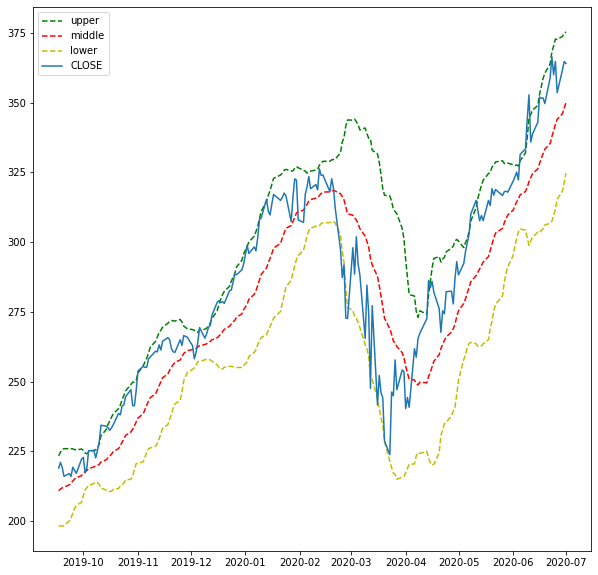

In [ ]:
 """
 Creating and Plotting Bollinger Bands
    """

plt.figure(figsize=(10,10))
plt.plot(df['upper_band'].iloc[-200:], 'g--', label="upper")
plt.plot(df['middle_band'].iloc[-200:], 'r--', label="middle")
plt.plot(df['lower_band'].iloc[-200:], 'y--', label="lower")
plt.plot(df["AAPL_close"].iloc[-200:], label="CLOSE")
plt.legend()
plt.show()

0 g
1 g
2 g
3 g
4 g
5 g
6 g
7 g
8 g
9 g
10 g
11 r
12 r
13 r
14 g
15 g
16 g
17 g
18 g
19 g


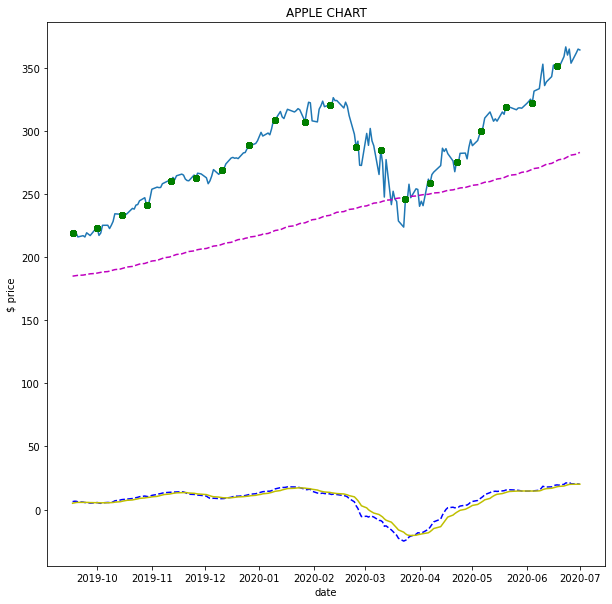

In [ ]:
 """
    Use matplotlib to create asset chart. plot will have Close price, Moving Average, MACD,EWMA,

    """
plt.figure(figsize=(10,10))
plt.plot(df["AAPL_close"].iloc[-200:], label="CLOSE")
plt.xlabel("date")
plt.ylabel("$ price")
plt.title("APPLE CHART")  
plt.plot(df['AAPL_MA'].iloc[-200:], 'm--', label="MA200")  
plt.plot(df["AAPL_MACD"].iloc[-200:], 'b--', label="MACD")
plt.plot(df["AAPL_Signal"].iloc[-200:], 'y-', label="MACD(EWMA9)")
random=df.loc[[i for j, i in enumerate(df.index[-200:]) if j %10 == 0]]
col=[]

for i in range(0,len(random)):
  if random['tomorrow_rises_relative_to_window'].iloc[i]==False:
      col.append('r') 
    

  else:
      col.append('g') 
      


#scatter plot




for i in range(0,len(random)):
  print(i,col[i])
  plt.plot(random["AAPL_close"],str(col[i])+'o', label="PREDICTION")
 



   
  




08/03/2020

- The closing price of a stock is the price of that stock at the close of the trading day. The adjusted closing price is a more complex analysis that uses the closing price as a starting point, but it takes into account factors such as dividends, stock splits and new stock offerings to determine a value

Features: 

- Moving Average 200= The 200 day moving average is a technical indicator used to analyze and identify long term trends.

- MACD:12-Period EMA − 26-Period EMA. If MACD signal is negative its sell position however will be buy position.is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. The MACD is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.

- ROC=$\frac{p_{t} - p_{t-1}}{p_{t-1}} * 100 $. Roc is a momentum oscillator. It calculates the percent change in price between periods. ROC takes the current price and compares it to a price "n" periods (user defined) ago


- D%=Oscilador estocastico=$\frac{p_{t} - min}{max-min}$.
https://es.wikipedia.org/wiki/Oscilador_estoc%C3%A1stico



- Prediction= Buy, Sell or Hold










In [ ]:
train=df.loc['2010-01-01':'2019-12-31']

test=df.loc[df['Year'] =="2020"]

X=df.drop(['tomorrow_rises_relative_to_window'], axis=1)
y=df['tomorrow_rises_relative_to_window']





In [ ]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [ ]:
btscv = BlockingTimeSeriesSplit(n_splits=5)
for train_index, test_index in btscv.split(X):
  print("TRAIN:", train_index, "TEST:", test_index)
X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
y_train, y_test = y[train_index], y[test_index]

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [ ]:
# test score
model = LogisticRegression()
model = model.fit(X_train,y_train)
predicted = model.predict(X_test)
print(metrics.confusion_matrix(y_test, predicted))
scores = cross_val_score(model, X_train, y_train, cv=btscv, scoring="f1")
print(scores)
scores= scores[np.logical_not(np.isnan(scores))]
print("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))

[[17 16]
 [ 3 62]]
[0.25       0.4        0.89655172 1.                nan]
Loss: 0.637 (+/- 0.318)


In [ ]:
y_train_pred = model.predict(X_train)
score = f1_score(y_train, y_train_pred)
print(f"F1 Score: {score}")
y_test_pred = model.predict(X_test)
score = f1_score(y_test, y_test_pred)
print(f"F1 Score: {score}")

F1 Score: 0.8631239935587762
F1 Score: 0.8671328671328672


In [ ]:
np.unique(y_train_pred)

array([0, 1])

In [ ]:
probability = model.predict_proba(X_test)
print (probability)



[[3.32920322e-01 6.67079678e-01]
 [4.49670623e-01 5.50329377e-01]
 [7.43702745e-01 2.56297255e-01]
 [6.27791800e-01 3.72208200e-01]
 [3.63507435e-01 6.36492565e-01]
 [1.14175036e-01 8.85824964e-01]
 [2.69831765e-01 7.30168235e-01]
 [1.75194574e-01 8.24805426e-01]
 [2.04000666e-01 7.95999334e-01]
 [6.10984797e-01 3.89015203e-01]
 [9.25582870e-01 7.44171297e-02]
 [8.07347115e-01 1.92652885e-01]
 [4.41972626e-01 5.58027374e-01]
 [1.00000000e+00 0.00000000e+00]
 [9.22727922e-01 7.72720781e-02]
 [8.38337088e-01 1.61662912e-01]
 [7.93586446e-01 2.06413554e-01]
 [4.09880876e-01 5.90119124e-01]
 [1.61523326e-01 8.38476674e-01]
 [5.57068450e-01 4.42931550e-01]
 [2.14203736e-01 7.85796264e-01]
 [2.53295042e-01 7.46704958e-01]
 [1.12159932e-01 8.87840068e-01]
 [8.77534023e-01 1.22465977e-01]
 [9.08774830e-01 9.12251695e-02]
 [8.43449031e-01 1.56550969e-01]
 [5.03899228e-01 4.96100772e-01]
 [3.63242205e-01 6.36757795e-01]
 [6.18314229e-01 3.81685771e-01]
 [5.94729239e-01 4.05270761e-01]
 [8.137412

In [ ]:
Pipeline(memory=None,'ran'RandomForestClassifier)

Pipeline(memory=None,
         steps=[('ran',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
param_grid = {
    "ran__n_estimators": [10,100,1000],
    "ran__max_depth": [10, 50, 100],
    "ran__max_features": ["auto", "log2"]
}

gs = GridSearchCV(
    model1,
    param_grid,
    scoring="f1",
    cv=btscv,
    return_train_score=True
).fit(X_train, y_train)


In [ ]:
def extract_gridsearch_cv_scores_by_rank(gs, rank=1):
    """
    NOTE: Multiple metrics in gs.cv_results_ are not supported.

    Args:
        rank (int):
            Extract cv scores for the parameters configuration that ranks this
            value based on cv score on test set.
    Returns:
        scores : dict of float arrays of shape (n_splits,)
            Array of scores of the estimator for each run of the cross validation.
            The possible keys for this ``dict`` are:
                ``test_score``
                    The score array for test scores on each cv split.
                ``train_score``
                    The score array for train scores on each cv split.
    """
    if rank > gs.cv_results_["rank_test_score"].max():
        raise ValueError("rank greater than number of searhes")
    result_index = np.argwhere(gs.cv_results_["rank_test_score"] == rank)

    train_score = []
    test_score = []
    for k in gs.cv_results_:
        if k.startswith("split"):
            split_score = gs.cv_results_[k]
            s = split_score[result_index]
            if k.endswith("_train_score"):
                train_score.append(s)
            elif k.endswith("_test_score"):
                test_score.append(s)
    return {"train_score": np.array(train_score), "test_score": np.array(test_score)}


print(f"Best parameters found for Random Forest Regressor: {gs.best_params_}")
scores = extract_gridsearch_cv_scores_by_rank(gs)
train_score, test_score = scores["train_score"], scores["test_score"]
print(f"Training Mean F1: {np.mean(train_score)} +/- {np.std(train_score)}")
print(f"Validation Mean F1: {np.mean(test_score)} +/- {np.std(test_score)}")




Best parameters found for Random Forest Regressor: {'ran__max_depth': 50, 'ran__max_features': 'log2', 'ran__n_estimators': 100}
Training Mean F1: 1.0 +/- 0.0
Validation Mean F1: 0.6941176470588235 +/- 0.4031021576238074


In [ ]:
model1 = gs.best_estimator_
model1.fit(X_train, y_train)
y_train_pred = model1.predict(X_train)
mae = f1_score(y_train, y_train_pred)
print(f"Training mean absolute error: {mae}")
y_test_pred = model1.predict(X_test)
mae = f1_score(y_test, y_test_pred)
print(f"Test mean absolute error: {mae}")


Training mean absolute error: 1.0
Test mean absolute error: 0.8724832214765101


In [ ]:
# test score
y_predicted = model1.predict(X_test)
print(metrics.confusion_matrix(y_test, y_predicted))
scores = cross_val_score(model1, X_train, y_train, cv=btscv, scoring="f1")
print(scores)
scores= scores[np.logical_not(np.isnan(scores))]
print("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))



[[ 0 33]
 [ 0 65]]
[0.         1.         0.47058824 1.         1.        ]
Loss: 0.694 (+/- 0.403)


In [ ]:
probability = model1.predict_proba(X_test)
print (probability)